# Resonances of Jupiter's moons, Io, Europa, and Ganymede

<h1>Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction</a></span></li><li><span><a href="#Mean-motions" data-toc-modified-id="Mean-motions-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Mean motions</a></span></li><li><span><a href="#Integration" data-toc-modified-id="Integration-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Integration</a></span></li><li><span><a href="#Eccentricities" data-toc-modified-id="Eccentricities-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Eccentricities</a></span></li><li><span><a href="#Positions" data-toc-modified-id="Positions-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Positions</a></span></li><li><span><a href="#Resonances" data-toc-modified-id="Resonances-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Resonances</a></span></li><li><span><a href="#Fourier-analysis" data-toc-modified-id="Fourier-analysis-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Fourier analysis</a></span></li><li><span><a href="#Export-data" data-toc-modified-id="Export-data-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Export data</a></span></li></ul></div>

## Introduction

Example provided by Deborah Lokhorst. In this example, the four Galilean moons of Jupiter are downloaded from HORIZONS and their orbits are integrated forwards in time. This is a well-known example of a 1:2:4 resonance (also called Laplace resonance) in orbiting bodies. We calculate the resonant arguments see them oscillate with time. We also perform an Fast Fourier Transform (FFT) on the x-position of Io, to look for the period of oscillations caused by the 2:1 resonance between Io and Europa.

Let us first import REBOUND, numpy and matplotlib. We then download the current coordinates for Jupiter and its moons from the NASA HORIZONS database. We work in units of AU, days and solar masses.

In [2]:
import rebound
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt


sim = rebound.Simulation()
sim.units = ('AU', 'days', 'Msun')

# We can add Jupiter and four of its moons by name, since REBOUND is linked to the HORIZONS database.
labels = ["Jupiter", "Io", "Europa","Ganymede","Callisto"]
sim.add(labels)

Searching NASA Horizons for 'Jupiter'... Found: Jupiter Barycenter (5).
Searching NASA Horizons for 'Io'... Found: Io (501).
Searching NASA Horizons for 'Europa'... Found: Europa (502).
Searching NASA Horizons for 'Ganymede'... Found: Ganymede (503).
Searching NASA Horizons for 'Callisto'... Found: Callisto (504).


## Mean motions

Let us now calculate the mean motions and periods of the inner three moons.

In [3]:
os = sim.calculate_orbits()
print("n_i (in rad/days) = %6.3f, %6.3f, %6.3f" % (os[0].n,os[1].n,os[2].n))
print("P_i (in days)     = %6.3f, %6.3f, %6.3f" % (os[0].P,os[1].P,os[2].P))

n_i (in rad/days) =  3.545,  1.771,  0.879
P_i (in days)     =  1.773,  3.548,  7.147


We can see that the mean motions of each moon are twice that of the moon inner to it and the periods of each moon are half that of the moon inner to it. This means we are close to a 4:2:1 resonance.

Let's move to the center of mass (COM) frame and plot the orbits of the four moons around Jupiter:

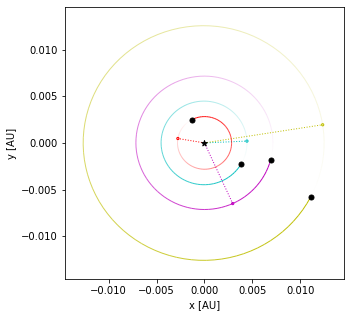

In [4]:
sim.move_to_com()
fig = rebound.OrbitPlot(sim, unitlabel="[AU]", color=True, trails=True, periastron=True)

Note that REBOUND automatically plots Jupiter as the central body in this frame, complete with a star symbol (not completely representative of this case, but it'll do).

## Integration

We can now start integrating the system forward in time. This example uses the symplectic Wisdom-Holman type `whfast` integrator since no close encounters are expected. The timestep is set to 5% of one of Io's orbits.

In [5]:
sim.integrator = "whfast"
sim.dt = 0.05 * os[0].P  # 5% of Io's period
Nout = 100000            # number of points to display
tmax = 80*365.25         # let the simulation run for 80 years
Nmoons = 4

Similar to as was done in the [Fourier analysis & resonances](FourierSpectrum.ipynb) example, we set up several arrays to hold values as the simulation runs.  This includes the positions of the moons, eccentricities, mean longitudes, and longitude of pericentres.

In [6]:
x = np.zeros((Nmoons,Nout))
ecc = np.zeros((Nmoons,Nout))
longitude = np.zeros((Nmoons,Nout))
varpi = np.zeros((Nmoons,Nout))

times = np.linspace(0.,tmax,Nout)
ps = sim.particles

for i,time in enumerate(times):
    sim.integrate(time)
    # note we use integrate() with the default exact_finish_time=1, which changes the timestep near 
    # the outputs to match the output times we want.  This is what we want for a Fourier spectrum, 
    # but technically breaks WHFast's symplectic nature.  Not a big deal here.
    os = sim.calculate_orbits()
    for j in range(Nmoons):
        x[j][i] = ps[j+1].x 
        ecc[j][i] = os[j].e
        longitude[j][i] = os[j].l
        varpi[j][i] = os[j].Omega + os[j].omega

## Eccentricities

If we plot the eccentricities as a function of time, one can see that they oscillate significantly for the three inner moons, which are in resonance with each other.  Contrasting with these large oscillations, is the smaller oscillation of the outer Galilean moon, Callisto, which is shown for comparison. The three inner moons are in resonance, 1:2:4, but Callisto is not quite in resonance with them, though it is expected to migrate into resonance with them eventually.

Also visible is the gradual change in eccentricity as a function of time: Callisto's mean eccentricity is decreasing and Ganymede's mean eccentricity is increasing.  This is a secular change due to the interactions with the inner moons.

/home/colin/anaconda3/envs/ml/lib/python3.6/site-packages/IPython/core/events.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/home/colin/anaconda3/envs/ml/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


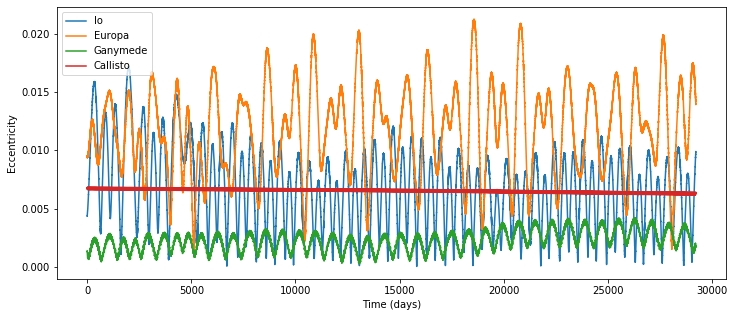

In [7]:
fig = plt.figure(figsize=(12,5))
ax = plt.subplot(111)
plt.plot(times,ecc[0],label=labels[1])
plt.plot(times,ecc[1],label=labels[2])
plt.plot(times,ecc[2],label=labels[3])
plt.plot(times,ecc[3],label=labels[4])
ax.set_xlabel("Time (days)")
ax.set_ylabel("Eccentricity")
plt.legend();

## Positions

We can plot their x-locations as a function of time as well, and observe their relative motions around Jupiter.

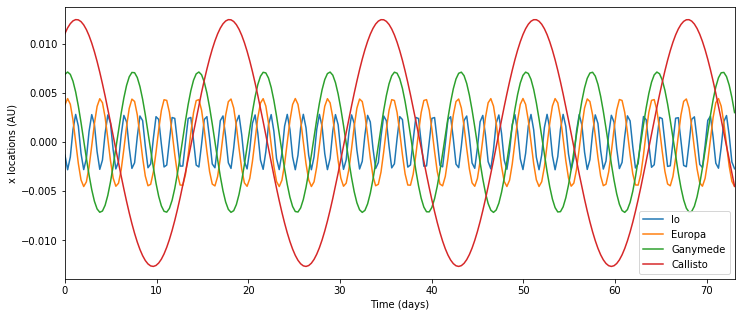

In [8]:
fig = plt.figure(figsize=(12,5))
ax = plt.subplot(111)
plt.plot(times,x[0],label=labels[1])
plt.plot(times,x[1],label=labels[2])
plt.plot(times,x[2],label=labels[3])
plt.plot(times,x[3],label=labels[4])
ax.set_xlim(0,0.2*365.25)
ax.set_xlabel("Time (days)")
ax.set_ylabel("x locations (AU)")
ax.tick_params()
plt.legend();

## Resonances

Resonances are identified by looking at the resonant arguments, which are defined as: 
   $$ \theta = (p + q)\lambda_{\rm out} - p \lambda_{\rm in} - q \omega_{\rm out/in}$$
 where $\lambda_{\rm out}$ and $\lambda_{\rm in}$ are the mean longitudes of the outer and inner bodies, respectively,
 and $\omega_{\rm out}$ is the longitude of pericenter of the outer/inner body.
 The ratio of periods is defined as : $$P_{\rm in}/P_{\rm out} ~= p / (p + q)$$

 If the resonant argument, $\theta$, oscillates but is constrained within some range of angles, then 
 there is a resonance between the inner and outer bodies. We call this libration of the angle $\theta$. 
 The trick is to find what the values of q and p are.  For our case, we can easily see that 
 there are two 2:1 resonances between the moons, so their resonant arguments would follow 
 the function:
    $$\theta = 2 \lambda_{\rm out} - \lambda_{\rm in} - \omega_{\rm out}$$
 To make the plotting easier, we can borrow this helper function that puts angles into 0 to 360 degrees 
 from another example (Fourier analysis & resonances), and define a new one that puts angles
 into -180 to 180 degrees.

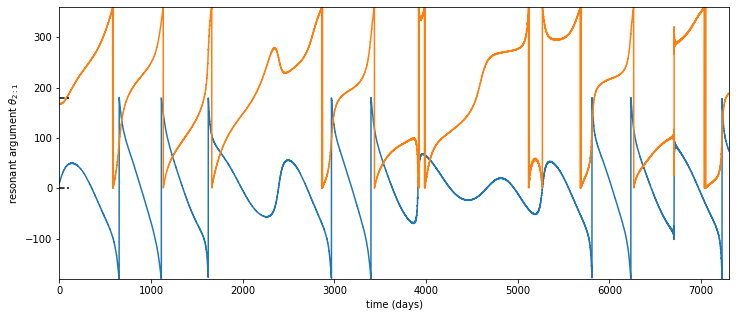

In [9]:
def zeroTo360(val):
    while val < 0:
        val += 2*np.pi
    while val > 2*np.pi:
        val -= 2*np.pi
    return (val*180/np.pi)

def min180To180(val):
    while val < -np.pi:
        val += 2*np.pi
    while val > np.pi:
        val -= 2*np.pi
    return (val*180/np.pi)

# We can calculate theta, the resonant argument of the 1:2 Io-Europa orbital resonance,
# which oscillates about 0 degrees:
theta = [min180To180(2.*longitude[1][i] - longitude[0][i] - varpi[0][i]) for i in range(Nout)]

# There is also a secular resonance argument, corresponding to the difference in the longitude of perihelions:
# This angle oscillates around 180 degs, with a longer period component.
theta_sec = [zeroTo360(-varpi[1][i] + varpi[0][i]) for i in range(Nout)]

fig = plt.figure(figsize=(12,5))
ax = plt.subplot(111)
ax.plot(times,theta)  
ax.plot(times,theta_sec) # secular resonance argument
ax.set_xlim([0,20.*365.25])
ax.set_ylim([-180,360.])
ax.set_xlabel("time (days)")
ax.set_ylabel(r"resonant argument $\theta_{2:1}$")
ax.plot([0,100],[180,180],'k--')
ax.plot([0,100],[0,0],'k--');

Io, Europa and Ganymede are in a Laplace 1:2:4 resonance,
which additionally has a longer period libration argument that depends on all three of 
their mean longitudes, that appears slightly in the other resonant arguments:

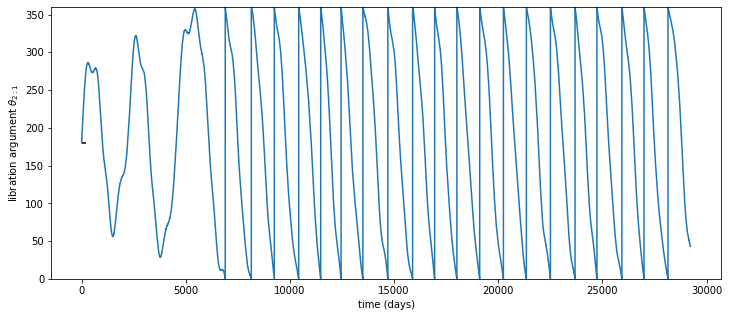

In [13]:
thetaL = [zeroTo360(-longitude[0][i] + 3.*longitude[1][i] - 2.*longitude[2][i]) for i in range(Nout)]

fig = plt.figure(figsize=(12,5))
ax = plt.subplot(111)

ax.plot(times,thetaL)
ax.set_ylim([0,360.])
ax.set_xlabel("time (days)")
ax.set_ylabel(r"libration argument $\theta_{2:1}$")
ax.plot([0,200],[180,180],'k--');

## Fourier analysis

For completeness, let's take a brief look at the Fourier transforms of the x-positions
of Io, and see if it has oscillations related to the MMR.
We are going to use the scipy Lomb-Scargle periodogram function, 
which is good for non-uniform time series analysis.  Therefore, 
if we used the IAS15 integrator, which has adaptive timesteps, 
this function would still work.

In [14]:
from scipy import signal
Npts = 3000

# look for periodicities with periods logarithmically spaced between 0.01 yrs and 100 yrs
logPmin = np.log10(0.001*365.25)
logPmax = np.log10(10.*365.25)

# set up a logspaced array from 0.01 to 100 yrs
Ps = np.logspace(logPmin,logPmax,Npts)
# calculate an array of corresponding angular frequencies
ws = np.asarray([2*np.pi/P for P in Ps])

# calculate the periogram (for Io) (using ws as the values for which to compute it)
periodogram = signal.lombscargle(times,x[0],ws)

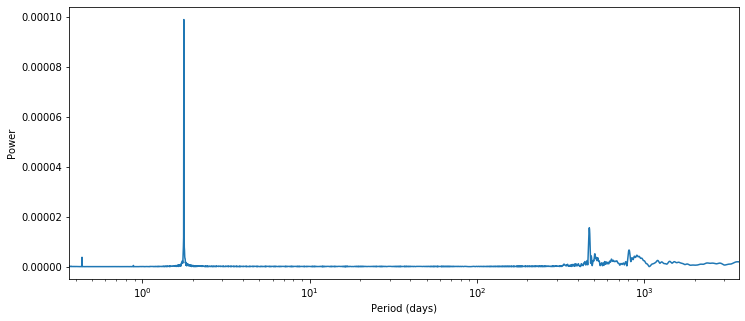

In [15]:
fig = plt.figure(figsize=(12,5))
ax = plt.subplot(111)

# Since the computed periodogram is unnormalized, taking the value A**2*N/4, 
# we renormalize the results by applying these functions inversely to the output:
ax.set_xscale('log')
ax.set_xlim([10**logPmin,10**logPmax])
ax.set_xlabel("Period (days)")
ax.set_ylabel("Power")
ax.plot(Ps,np.sqrt(4*periodogram/Nout));

The first spike at about 2 days is caused by the motion of Io around Jupiter
in its orbit.

The other spikes, corresponding to oscillations with periods of around 1 year, 
are caused by the MMR of the moons.  The largest spike at ~1.3 years is the from 
the 1:2 resonance of the two inner moons, Io and Europa.

## Export data

It would be useful to have the simulation data in a readable format for situations where REBOUND isn't (or can't be) installed. The following code writes 4 astropy tables then checks that at least one can be read back in.

In [37]:
# from astropy.table import Table
# import astropy.units as u

# bodies = ["Io", "Europa","Ganymede","Callisto"]
# for i in range(len(bodies)):
#     data = Table()
#     data['time'] = times * u.day
#     data['x'] = x[i] * u.AU
#     data['e'] = ecc[i]
#     data['longitude'] = (longitude[i]*u.radian).to(u.degree)
#     data['varpi'] = (varpi[i]*u.radian).to(u.degree)
#     data.write(bodies[i]+'.fits')

# Io = Table.read('Io.fits')
# Io

time,x,e,longitude,varpi
d,AU,,deg,deg
float64,float64,float64,float64,float64
0.0,-0.001321053576063158,0.0043502417422881115,-241.65700284794426,-189.60563947459116
0.29220292202922027,-0.002809149327993943,0.004355497681667045,-182.31244875438242,-189.81638625193867
0.5844058440584405,-0.001514771562275866,0.00435516179683641,-122.967922473049,-190.030114870379
0.8766087660876608,0.0012742040650158793,0.004360011503570393,-63.62092298166924,-190.27886999219533
1.168811688116881,0.00282515993747753,0.004361436112122405,-364.27191860456367,-190.37362090037652
1.4610146101461012,0.001635276126484914,0.004344299955549722,-304.92473522638585,-190.45163643822457
1.7532175321753216,-0.0011470026745097701,0.004337082015108344,-245.5787031040483,-190.48191825426153
2.045420454204542,-0.0027941801804978977,0.0043709842465124125,-186.236462015917,-191.00030899808866


In [65]:
# moons = []
# for i in range(len(bodies)):
#     m = sim.particles[i+1]
#     orbit = (bodies[i], m.a, m.e, m.inc, m.P)
#     moons.append(orbit)
# t = Table()
# t['moon'] = [m[0] for m in moons]
# t['a'] = ([m[1] for m in moons]*u.AU).to(u.km)
# t['e'] = ([m[2] for m in moons]*u.radian).to(u.degree)
# t['i'] = [m[3] for m in moons]
# t['P'] = [m[4] for m in moons]*u.day
# t.write('JupiterMoons.fits')
# t

moon,a,e,i,P
,km,deg,,d
str8,float64,float64,float64,float64
Io,422101.2691415224,0.565386945454432,0.039038133248204904,1.7716205775596672
Europa,671474.7210516771,0.8036501058887978,0.04380379278220206,3.5545509369934476
Ganymede,1069586.204710489,0.0975539180085016,0.040314226257651,7.145736332699823
Callisto,1881565.6721480873,0.36321447529458395,0.03499926933631003,16.672090869172656
